# Import the Neccesary Libraries #

In [1]:
# Import the neccesary libraries needed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
from numpy import insert
import os
import time

# keras tuner for hyperparameter tuning
import keras_tuner as kt

# tensorflow Libraries
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow import feature_column
from tensorflow.keras import layers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

# Import the CSV Training and Testing Data Sets #

In [2]:
# Import the csv's (IMPORTANT: You need at least 16 Gb of RAM to proceed)
train=pd.read_csv(r'C:\Users\Daniel\OneDrive - University of Massachusetts Dartmouth\ECE457_Senior_Design_ECE5\CSV_Files\\0001_1404.002NR_port.csv')
test=pd.read_csv(r'C:\Users\Daniel\OneDrive - University of Massachusetts Dartmouth\ECE457_Senior_Design_ECE5\CSV_Files\\0001_1404.002NR_stbd.csv')

In [ ]:
train

In [ ]:
test

# Split up the Features and Labels from both the Training and Testing Datasets #

In [3]:
# Split up the features and labels from both the training and testing datasets
x_train=train.iloc[:,3:24]
#x_train['TWTT']=train.iloc[:,28]  I feel as though the TWTT has NO impact on the DOA so we should NOT include it in training
x_train['Amplitude']=train.iloc[:,29]


x_test=test.iloc[:,3:24]
#x_test['TWTT']=test.iloc[:,28] I feel as though the TWTT has NO impact on the DOA so we should NOT include it in training
x_test['Amplitude']=test.iloc[:,29]

y_train=train.iloc[:,26]

y_test=test.iloc[:,26]

In [ ]:
y_test

In [ ]:
x_train

# Scale the Feaures from 0 to 1 so that Training is Easier for the Model #

In [4]:
# Scale the Features and Labels from [-1,1]
s1=MinMaxScaler(feature_range=(0,1)) #try (-1,1)
x_train_scale=s1.fit_transform(x_train)

s2=MinMaxScaler(feature_range=(0,1)) #try (-1,1)
x_test_scale=s2.fit_transform(x_test)
x_test_scale=x_test_scale

# Scale DOA's from (0 to 1)
s3=MinMaxScaler(feature_range=(0,1))
#y_train_scale = s3.fit_transform(train[['DOA']])
y_train_scale= y_train.to_numpy()

s4=MinMaxScaler(feature_range=(0,1))
#y_test_scale = s4.fit_transform(test[['DOA']])
y_test_scale= y_test.to_numpy()

print(len(x_train_scale))
print(len(y_train_scale))

4984691
4984691


# Shift the DOA's to the Left by one so that the Current I and Q data Align with the current DOA while using TimeSeriesGenerator to Window the Data #

In [5]:
# Shift the DOA to the left by one to use the current DOA label with the current I and Q data.
# Normally the TimeseriesGenerator function uses past values to predict the future but we would like current data to help predict the current samples' DOA
print(len(x_train_scale))
print(len(y_test_scale))
y_train_scale=insert(y_train_scale, 0, 0)
y_train_scale=np.delete(y_train_scale, -1)
y_test_scale=insert(y_test_scale, 0,0)
y_test_scale=np.delete(y_test_scale, -1)
print(y_train_scale)
print(len(y_train_scale))
print(y_test_scale)
print(len(y_test_scale))

4984691
5224717
[ 0.         71.64600062 70.74600061 ... 80.2140007  80.2440007
 80.2680007 ]
4984691
[ 0.         72.31800063 71.37600062 ... 79.83600069 79.69800069
 79.87800069]
5224717


# Create the Windows Neccesary for the LSTM model using the TimeSeriesGenerator Function #

In [33]:
# Create the windows neccesary for the LSTM model within tensorflow keras
# Below are the arguments of the timeseries_dataset_from_array function
# The function takes a numpy array and makes a timeseries out of it
NumSampsPerPing= 4278
data=x_train_scale # the data to make the windows
targets=y_train_scale # time steps in the data (don't need)
sequence_length=10 # window length
sequence_stride=1# period between successive output sequences
sampling_rate=1 # period between successive individual timesteps     within sequences
batch_size=64 # number of time series samples in each batch
shuffle=True #shuffle the data before making the windows
seed=None # is related to shuffle
start_index=None # is related to shuffle
end_index=None # is related to shuffle
n_features=22

test_data=x_test_scale
test_targets=y_test_scale

dataRows= data.shape[0]
validationStartRow= dataRows-NumSampsPerPing*281
#print(validationStartRow, ',', dataRows)

#split up the training data into a validation set and training set
train_data=data[:validationStartRow-1]
train_targets=targets[:validationStartRow-1]
val_data=data[validationStartRow:]
val_targets=targets[validationStartRow:]

inputs=TimeseriesGenerator(data=train_data, targets=train_targets,length=sequence_length, batch_size=batch_size, shuffle=True)
val_inputs=TimeseriesGenerator(data=val_data, targets=val_targets,length=sequence_length, batch_size=batch_size, shuffle=True)


#test_inputs=TimeseriesGenerator(test_data[0:40000], -1*test_targets[0:40000],sequence_length, batch_size)
test_inputs=TimeseriesGenerator(data=test_data, targets=test_targets,length=sequence_length, batch_size=batch_size)

#inputs=tf.keras.preprocessing.timeseries_dataset_from_array(data, targets, sequence_length, sequence_stride, sampling_rate, batch_size, shuffle)
#print(type(inputs))

print('done')

done


In [ ]:
# print the first couple of samples to see if everything everything is lining up
for i in range(100):
	x, y = inputs[i]
	print('%s => %s' % (x, y))

In [ ]:
# print the first couple of samples to see if everything everything is lining up
for i in range(100):
	x, y = test_inputs[i]
	print('%s => %s' % (x, y))

# Define the Model's Structure #

In [34]:
# With all the preproccessing done, it is time to define the model
# Define the LSTM Model
# Make sure to ALWAYS use return_sequences=True when using series LSTM layers. MAKE SURE THAT THE LAST LSTM LAYER DOES NOT HAVE RETURN SEQUENCES=TRUE SINCE THE OUTPUT WILL BE 3D. return sequences makes the output shape of the layer
# equal its input. so in this case 3d.
model= Sequential()
model.add(LSTM(units=22, activation='tanh', input_shape=(sequence_length,n_features), return_sequences=False, name='LSTM1'))
#model.add(Dense(units=100, activation='relu'))
#model.add(Dropout(0.2))

#model.add(LSTM(units=416, activation='relu', return_sequences=True,name='LSTM2'))
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=60, activation='relu'))
model.add(Dense(units=60, activation='relu'))

#model.add(Dropout(0.2))

#model.add(LSTM(units=512, activation='relu', name='LSTM3', ))
#model.add(Dense(units=100))
#model.add(Dropout(0.2))

#model.add(LSTM(units=320, activation='relu', return_sequences=True,name='LSTM4'))
#model.add(Dense(units=100))
#model.add(Dropout(0.2))

#model.add(LSTM(units=480, activation='relu', return_sequences=True, name='LSTM5'))
#model.add(Dense(units=100))
#model.add(Dropout(0.2))


model.add(Dense(units=1)) #one output (namely: DOA)


In [ ]:
model.summary()

In [ ]:
def scheduler(epoch,lr):
    if epoch>=1:
        return lr
    elif epoch>=2 | epoch<=4:
        return lr/1.65
    else:
        return lr*tf.math.exp(-.5)

# Train the Model using the Specified Hyperparmeters #

Epoch 1/20
59101/59103 [============================>.] - ETA: 0s - loss: 8.5982 - mean_squared_error: 33.9758 - root_mean_squared_error: 5.8289

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 383s 6ms/step - loss: 8.5983 - mean_squared_error: 33.9765 - root_mean_squared_error: 5.8289 - val_loss: 6.3501 - val_mean_squared_error: 22.2399 - val_root_mean_squared_error: 4.7159
Epoch 2/20
59103/59103 [==============================] - ETA: 0s - loss: 5.7231 - mean_squared_error: 19.2415 - root_mean_squared_error: 4.3865

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 399s 7ms/step - loss: 5.7231 - mean_squared_error: 19.2415 - root_mean_squared_error: 4.3865 - val_loss: 5.3671 - val_mean_squared_error: 19.1221 - val_root_mean_squared_error: 4.3729
Epoch 3/20
59101/59103 [============================>.] - ETA: 0s - loss: 5.4837 - mean_squared_error: 18.5239 - root_mean_squared_error: 4.3039

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 390s 7ms/step - loss: 5.4838 - mean_squared_error: 18.5239 - root_mean_squared_error: 4.3039 - val_loss: 4.4181 - val_mean_squared_error: 13.6463 - val_root_mean_squared_error: 3.6941
Epoch 4/20
59100/59103 [============================>.] - ETA: 0s - loss: 5.4187 - mean_squared_error: 18.3867 - root_mean_squared_error: 4.2880

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 392s 7ms/step - loss: 5.4188 - mean_squared_error: 18.3876 - root_mean_squared_error: 4.2881 - val_loss: 5.0518 - val_mean_squared_error: 18.4073 - val_root_mean_squared_error: 4.2904
Epoch 5/20
59100/59103 [============================>.] - ETA: 0s - loss: 5.3293 - mean_squared_error: 18.0192 - root_mean_squared_error: 4.2449

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 388s 7ms/step - loss: 5.3293 - mean_squared_error: 18.0188 - root_mean_squared_error: 4.2449 - val_loss: 4.0370 - val_mean_squared_error: 12.4528 - val_root_mean_squared_error: 3.5288
Epoch 6/20
59097/59103 [============================>.] - ETA: 0s - loss: 5.2607 - mean_squared_error: 17.7889 - root_mean_squared_error: 4.2177

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 389s 7ms/step - loss: 5.2605 - mean_squared_error: 17.7882 - root_mean_squared_error: 4.2176 - val_loss: 4.4985 - val_mean_squared_error: 14.8473 - val_root_mean_squared_error: 3.8532
Epoch 7/20
59102/59103 [============================>.] - ETA: 0s - loss: 5.2106 - mean_squared_error: 17.5816 - root_mean_squared_error: 4.1930

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 383s 6ms/step - loss: 5.2106 - mean_squared_error: 17.5814 - root_mean_squared_error: 4.1930 - val_loss: 4.5853 - val_mean_squared_error: 14.2638 - val_root_mean_squared_error: 3.7767
Epoch 8/20
59099/59103 [============================>.] - ETA: 0s - loss: 5.1645 - mean_squared_error: 17.5001 - root_mean_squared_error: 4.1833

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 387s 7ms/step - loss: 5.1644 - mean_squared_error: 17.4996 - root_mean_squared_error: 4.1833 - val_loss: 4.4839 - val_mean_squared_error: 16.3311 - val_root_mean_squared_error: 4.0412
Epoch 9/20
59103/59103 [==============================] - ETA: 0s - loss: 5.1195 - mean_squared_error: 17.3698 - root_mean_squared_error: 4.1677

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 394s 7ms/step - loss: 5.1195 - mean_squared_error: 17.3698 - root_mean_squared_error: 4.1677 - val_loss: 4.0408 - val_mean_squared_error: 12.4609 - val_root_mean_squared_error: 3.5300
Epoch 10/20
59099/59103 [============================>.] - ETA: 0s - loss: 5.1093 - mean_squared_error: 17.4068 - root_mean_squared_error: 4.1722

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 394s 7ms/step - loss: 5.1092 - mean_squared_error: 17.4065 - root_mean_squared_error: 4.1721 - val_loss: 4.2964 - val_mean_squared_error: 13.9232 - val_root_mean_squared_error: 3.7314
Epoch 11/20
59103/59103 [==============================] - 384s 7ms/step - loss: 5.1447 - mean_squared_error: 17.7278 - root_mean_squared_error: 4.2104 - val_loss: 4.2853 - val_mean_squared_error: 13.6652 - val_root_mean_squared_error: 3.6966
Epoch 12/20
59098/59103 [============================>.] - ETA: 0s - loss: 5.0768 - mean_squared_error: 17.4040 - root_mean_squared_error: 4.1718

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 367s 6ms/step - loss: 5.0770 - mean_squared_error: 17.4047 - root_mean_squared_error: 4.1719 - val_loss: 4.2454 - val_mean_squared_error: 13.6589 - val_root_mean_squared_error: 3.6958
Epoch 13/20
59099/59103 [============================>.] - ETA: 0s - loss: 5.0284 - mean_squared_error: 17.0658 - root_mean_squared_error: 4.1311

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 368s 6ms/step - loss: 5.0284 - mean_squared_error: 17.0654 - root_mean_squared_error: 4.1310 - val_loss: 3.9942 - val_mean_squared_error: 12.5338 - val_root_mean_squared_error: 3.5403
Epoch 14/20
59103/59103 [==============================] - 367s 6ms/step - loss: 5.0287 - mean_squared_error: 17.2140 - root_mean_squared_error: 4.1490 - val_loss: 4.3178 - val_mean_squared_error: 15.1681 - val_root_mean_squared_error: 3.8946
Epoch 15/20
59097/59103 [============================>.] - ETA: 0s - loss: 5.0103 - mean_squared_error: 17.1917 - root_mean_squared_error: 4.1463

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 365s 6ms/step - loss: 5.0103 - mean_squared_error: 17.1913 - root_mean_squared_error: 4.1462 - val_loss: 3.9873 - val_mean_squared_error: 11.9051 - val_root_mean_squared_error: 3.4504
Epoch 16/20
59098/59103 [============================>.] - ETA: 0s - loss: 5.0049 - mean_squared_error: 17.2456 - root_mean_squared_error: 4.1528

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 359s 6ms/step - loss: 5.0048 - mean_squared_error: 17.2447 - root_mean_squared_error: 4.1527 - val_loss: 3.8260 - val_mean_squared_error: 11.5431 - val_root_mean_squared_error: 3.3975
Epoch 17/20
59096/59103 [============================>.] - ETA: 0s - loss: 4.9294 - mean_squared_error: 16.8632 - root_mean_squared_error: 4.1065

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 361s 6ms/step - loss: 4.9293 - mean_squared_error: 16.8624 - root_mean_squared_error: 4.1064 - val_loss: 4.1067 - val_mean_squared_error: 13.5765 - val_root_mean_squared_error: 3.6846
Epoch 18/20
59103/59103 [==============================] - 348s 6ms/step - loss: 4.9647 - mean_squared_error: 17.1091 - root_mean_squared_error: 4.1363 - val_loss: 4.1753 - val_mean_squared_error: 14.2113 - val_root_mean_squared_error: 3.7698
Epoch 19/20
59103/59103 [==============================] - 372s 6ms/step - loss: 4.9363 - mean_squared_error: 16.9071 - root_mean_squared_error: 4.1118 - val_loss: 5.0850 - val_mean_squared_error: 20.3053 - val_root_mean_squared_error: 4.5061
Epoch 20/20
59103/59103 [==============================] - ETA: 0s - loss: 4.8914 - mean_squared_error: 16.7456 - root_mean_squared_error: 4.0921

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


59103/59103 [==============================] - 367s 6ms/step - loss: 4.8914 - mean_squared_error: 16.7456 - root_mean_squared_error: 4.0921 - val_loss: 3.9438 - val_mean_squared_error: 12.1235 - val_root_mean_squared_error: 3.4819
The total run time to train was 7557.21 seconds


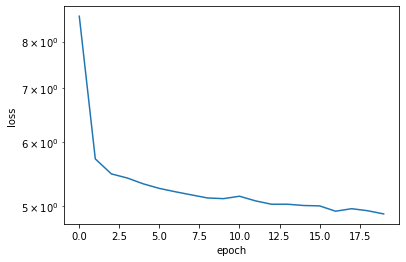

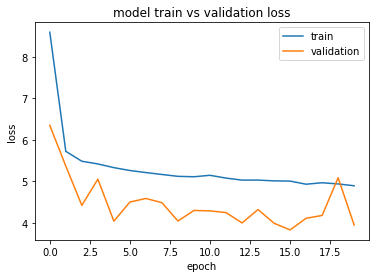

In [35]:
#Now it is time to train the model
opt=tf.keras.optimizers.Adam(learning_rate=3e-4)#, momentum=0.9)#,decay=1e-5)
mMSE= tf.keras.metrics.MeanSquaredError()
mRMSE= tf.keras.metrics.RootMeanSquaredError()
huber=tf.keras.losses.Huber(delta=10) #delta is a parameter to change

model.compile(loss=huber, optimizer=opt, metrics=[mMSE,mRMSE])

# Allow for early stopping so that the model does not overfit the training dataset
es= EarlyStopping(monitor='loss', mode='min',verbose=1,patience=10)
cp= ModelCheckpoint('model/',monitor='loss', save_best_only=True) #need validation data
#callback=tf.keras.callbacks.LearningRateScheduler(scheduler)

t0=time.time()
history= model.fit(inputs,epochs=20, batch_size=None,verbose=1,validation_steps=5360, callbacks=[es, cp],validation_data=val_inputs, shuffle=True)#, max_queue_size=200) ##### Make sure to put validation_steps=5360
#history= model.fit(inputs,epochs=3, batch_size=None)
t1=time.time()
print("The total run time to train was %.2f seconds"%(t1-t0))

# plot the loss function
plt.figure()
plt.semilogy(history.history['loss'])
plt.xlabel('epoch'); plt.ylabel('loss')


plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model train vs validation loss')
plt.legend(['train','validation'], loc='upper right')


# Using the Model, Predict the DOA's on the Testing Dataset #

In [23]:
#use the model to predict on the testing dataset
#for right now test_inputs has only the 40,001 samples
predicted=model.predict(test_inputs, verbose=1)

163273/163273 [==============================] - 276s 2ms/step


In [ ]:
##predict on the training set just to see if the model has leant at all
predicted_train=model.predict(inputs, verbose=1)

# Compare the predicted and actual DOA's numerically #

In [ ]:
print(predicted_train[0:21])

In [ ]:
print(y_test[10:32])

In [36]:
print(predicted[0:21])

[[68.65787 ]
 [66.82069 ]
 [67.624855]
 [67.446785]
 [67.31851 ]
 [67.26968 ]
 [67.31348 ]
 [66.57227 ]
 [66.63945 ]
 [69.60185 ]
 [70.54715 ]
 [70.813065]
 [70.81222 ]
 [62.58935 ]
 [70.40813 ]
 [65.393036]
 [62.541683]
 [74.34593 ]
 [65.56665 ]
 [71.88881 ]
 [71.696175]]


In [37]:
print(y_test[10:31])

10    63.660001
11    65.682001
12    65.334001
13    65.004001
14    64.704001
15    64.416001
16    64.146001
17    75.102001
18    75.846001
19    75.936001
20    76.344001
21    76.524001
22    57.714001
23    57.774001
24    67.908001
25    66.780001
26    78.114001
27    66.972001
28    62.796001
29    64.206001
30    66.114001
Name: DOA, dtype: float64


# Compare the Actual Testing DOA's to the Predicted DOA's Graphically #

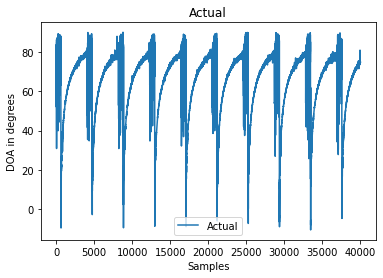

In [38]:
plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual'])
plt.show()


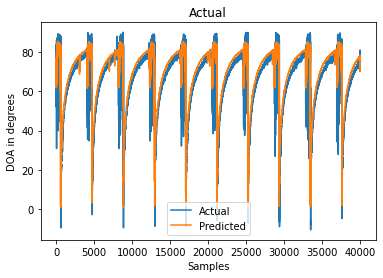

In [39]:
plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.plot(predicted[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()

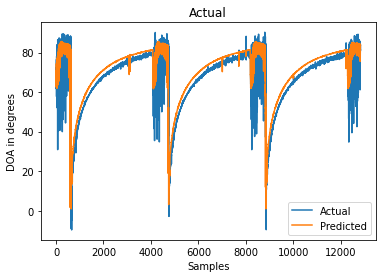

In [40]:
plt.figure(facecolor='white')
plt.plot(y_test[0:NumSampsPerPing*3])
plt.plot(predicted[0:NumSampsPerPing*3])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()

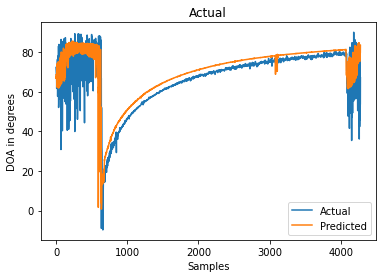

In [41]:
plt.figure(facecolor='white')
plt.plot(y_test[0:NumSampsPerPing])
plt.plot(predicted[0:NumSampsPerPing])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()

In [ ]:
plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.plot(predicted_train[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()

# Put the predicted DOA's back into a csv file format #

RUN THIS IF YOU WANT TO MAKE THE PREDICTED STBD CSV

In [42]:
#Ping |  Num Samp Num | PORT or STBD (0 or 1) |  TWTT |  Predicted DOA   <=======Output columns.
OutputCSVdf=test.iloc[:,[0,1,2,3]]
#OutputCSVdf= pd.DataFrame(test.iloc[:,[0,1,2,3]], columns=['PingNumber','SampNumber','PortStbd', 'SampleTime'])
zerosArray= np.arange(sequence_length)*0
predictedShifted=np.append(zerosArray, predicted)
Predicteddf= pd.DataFrame(predictedShifted,columns=['PredictedDOA'])
OutputCSVdf=OutputCSVdf.join(Predicteddf)

In [43]:
OutputCSVdf

,PingNum,SampleNum,PortStbd,SampleTimeDelay,PredictedDOA
0,87443,18,1,0.000261,0.000000
1,87443,19,1,0.000276,0.000000
2,87443,20,1,0.000292,0.000000
3,87443,21,1,0.000307,0.000000
4,87443,22,1,0.000323,0.000000
...,...,...,...,...,...
5224712,88720,4305,1,0.066105,81.370316
5224713,88720,4306,1,0.066120,81.358650
5224714,88720,4307,1,0.066136,81.354164
5224715,88720,4308,1,0.066151,81.352692


In [44]:
OutputCSVdf.to_csv(path_or_buf="C:\\Users\\Daniel\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\AIOutput_CSV_Files\\DL_PredictedCSVs\\DL_PredictedOutputTest_Row33_3_15_2022.csv")

# Save the model #

In [ ]:
tf.keras.models.save_model(model,filepath="C:\\Users\\Daniel\\Desktop\\Models\\model_21.8572Percent.h5")

# Load Previous Models and Use them to Predict #

Grab the saved model from the checkpoint

In [ ]:
saved_checkpoint_model=tf.keras.models.load_model(filepath="C:\\Users\\Daniel\\Desktop\\MLDOA_ET\\ML Code\\model")

In [ ]:
saved_checkpoint_model.summary()

In [ ]:
predicted_checkpoint=saved_checkpoint_model.predict(test_inputs, verbose=1)

In [ ]:
predicted_checkpoint

In [ ]:
plt.figure(facecolor='white')
plt.plot(y_test[0:NumSampsPerPing])
plt.plot(predicted_checkpoint[0:NumSampsPerPing])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()

In [ ]:
#Ping |  Num Samp Num | PORT or STBD (0 or 1) |  TWTT |  Predicted DOA   <=======Output columns.
OutputCSVdf=test.iloc[:,[0,1,2,3]]
#OutputCSVdf= pd.DataFrame(test.iloc[:,[0,1,2,3]], columns=['PingNumber','SampNumber','PortStbd', 'SampleTime'])
zerosArray= np.arange(sequence_length)*0
predictedShifted=np.append(zerosArray, predicted_checkpoint)
Predicteddf= pd.DataFrame(predictedShifted,columns=['PredictedDOA'])
OutputCSVdf=OutputCSVdf.join(Predicteddf)

In [ ]:
OutputCSVdf

In [ ]:
OutputCSVdf.to_csv(path_or_buf="C:\\Users\\Daniel\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\AIOutput_CSV_Files\\DL_PredictedOutputTestThree3_12_2022.csv")

Grab any saved model that is saved as an h5 file

In [ ]:
saved_model=tf.keras.models.load_model(filepath="C:\\Users\\Daniel\\Desktop\\Models\\model_10.83Percent.h5")

In [ ]:
predicted_saved=saved_model.predict(test_inputs, verbose=1)

In [ ]:
plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.plot(predicted_saved[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()

# EVERYTHING BELOW HERE IS MY KERAS TUNER STUFF. VIEWER REGRESSION IS ADVISED. #

In [ ]:
LOG_DIR = f"{int(time.time())}"

In [ ]:
def model_builder(hp):
    model= Sequential()

    #try
    hp_units_1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    model.add(LSTM(units=hp_units_1, activation='tanh', input_shape=(sequence_length,n_features), return_sequences=True))
    model.add(Dropout(0.2))

    for i in range(hp.Int("n_layers",1,2)):
        model.add(LSTM(units=hp.Int(f"LSTM_{i}_units", min_value=32, max_value=512, step=32), activation='tanh', input_shape=(sequence_length,n_features), return_sequences=True))
        model.add(Dropout(0.2))

    #hp_units_2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    #model.add(LSTM(units=hp_units_2, activation='relu',  return_sequences=True))
    #model.add(Dropout(0.2))

    #hp_units_3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    #model.add(LSTM(units=hp_units_3, activation='relu', return_sequences=True))
    #model.add(Dropout(0.2))

    #hp_units_4 = hp.Int('units4', min_value=32, max_value=512, step=32)
    #model.add(LSTM(units=hp_units_4, activation='relu',  return_sequences=True))
    #model.add(Dropout(0.2))

    model.add(Dense(units=1)) #one output (namely: DOA)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    opt=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate,decay=1e-5)
    model.compile(loss='mse', optimizer=opt)

    return model

In [ ]:
es= EarlyStopping(monitor='loss', mode='min',verbose=1,patience=10)

tuner = kt.RandomSearch(model_builder, objective='loss', max_trials=1000, directory=os.path.normpath('C:/'))
tuner.search(inputs,steps_per_epoch=2000,epochs=20,verbose=1, callbacks=[es])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. 
""")

In [ ]:
print(f"""
Unit1: {best_hps.get('units1')} learning rate {best_hps.get('learning_rate')} LSTM0 units: {best_hps.get('LSTM_0_units')} LSTM1 units: {best_hps.get('LSTM_1_units')} 
""")